In [ ]:
!pip install --upgrade --force-reinstall --no-deps --quiet kaggle
!pip install --quiet -U albumentations

     |████████████████████████████████| 61kB 3.7MB/s 
     |████████████████████████████████| 81kB 4.2MB/s 
     |████████████████████████████████| 38.2MB 73kB/s 
     |████████████████████████████████| 952kB 34.5MB/s 


#Libraries


In [ ]:
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from collections import Counter
import dlib
import random

import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


#Helpful functions

In [ ]:
def display_image_grid(images, labels, landmarks = None, size=(3,4)):
    indices = np.random.randint(0, len(labels), size[0]*size[1]).tolist()
    figure, ax = plt.subplots(nrows=size[0], ncols=size[1], figsize=(12, 6))
    for i, idx in enumerate(indices):
        image = images[idx]
        # image = cv2.cvtColor(image.astype('float32') * 255, cv2.COLOR_GRAY2BGR).astype(np.uint8)
        if landmarks:
          for xy in landmarks[idx]:
            cv2.circle(image, (xy[0], xy[1]), 3, (17, 131, 171), -1)
        true_label = classes[labels[idx]]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(true_label, color="green")
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

# Loading Data 


In [ ]:
# adding api token into correct place
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/ACV/kaggle.json /root/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#downloading dataset and place it into dataset folder
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip -qq challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d dataset/
!rm challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!tar -xf /content/dataset/fer2013.tar.gz
!mv /content/fer2013 /content/dataset
!rm /content/dataset/fer2013.tar.gz

 99% 282M/285M [00:03<00:00, 85.3MB/s]
100% 285M/285M [00:03<00:00, 97.0MB/s]


##Creating dataset

In [ ]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

In [ ]:
def create_dataset(data, train=True):
    if train:
      data.dropna(subset=["pixels", "emotion"], inplace=True)
      labels = data['emotion'].tolist()

    faces = []
    pixels = data['pixels'].tolist() 

    for pixel_sequence in pixels:
      face = np.fromstring(pixel_sequence, dtype='int', sep=' ')
      max_ = face.max()
      face = [ p / max_ for p in face]
      face = np.reshape(face, (48,48))
      face = cv2.cvtColor(face.astype('float32') * 255, cv2.COLOR_GRAY2BGR).astype(np.uint8)
      face = cv2.resize(face, (180,180))
      faces.append(face)

    if train:
      return faces, labels
    else:
      return faces

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


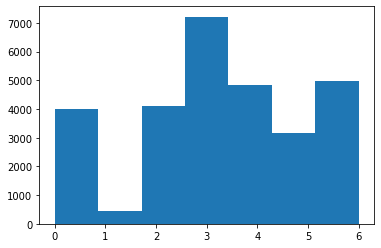

Distribution of classes. Train size = 28709


In [ ]:
train_data = pd.read_csv("/content/dataset/train.csv")
images, labels = create_dataset(train_data)
plt.hist(train_data['emotion'], bins=7)
plt.show()
print("Distribution of classes. Train size =", len(train_data))
del train_data

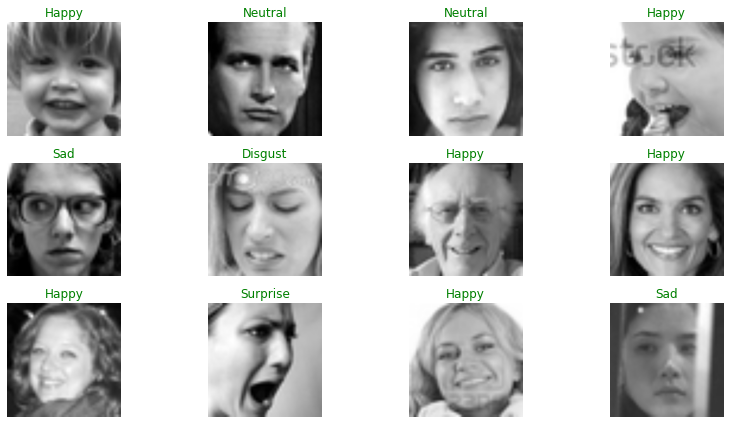

In [ ]:
display_image_grid(images, labels) #check dataset loaded correctly

##Perform augmentation

In [ ]:
transform = A.Compose(
    [
        # Just a bunch of random augmentations
        A.HorizontalFlip(),
        A.Rotate(p=.5, limit=(-19, 19), interpolation=2, border_mode=1),
        A.CoarseDropout(p=.5, max_holes=43, max_height=8, max_width=8, min_holes=8, min_height=8, min_width=8),
        A.Downscale(p=.5, scale_min=0.31, scale_max=0.79, interpolation=3),
        A.RandomBrightnessContrast(p=.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
        A.GaussNoise(p=.5, var_limit=(10.0, 50.0)),
        A.OpticalDistortion(p=.5, distort_limit=(-0.13, 1.03), shift_limit=(-0.13, 0.23), interpolation=1, border_mode=1),
        # A.ElasticTransform(p=.5, alpha=1.0, sigma=50.0, alpha_affine=50.0, interpolation=0, border_mode=1, value=(0, 0, 0), mask_value=None, approximate=False),
        A.MotionBlur(p=.5, blur_limit=(3, 13)),
        # ToTensorV2(),
    ]
)

# method to enrich meager classes
def do_augmentation(images, labels, max=10000):
  augmented_images = images
  augmented_labels = labels
  num_of_samples = Counter(labels).most_common()
  # max = num_of_samples[0][1] # finding maximum number of samples
  search_indexies = np.array(labels) # need to find indexies of class samples to perform augmentation

  for class_id, count in num_of_samples:
    to_add = max-count
    augmented_labels.extend([class_id]*to_add) # adding labels
    class_image_indexies = np.random.choice(np.where(search_indexies == class_id)[0], to_add).tolist() #creating a sample of indexies to put into transform
    
    for idx in class_image_indexies:
      augmented_images.append(transform(image=images[idx])["image"]) # augmentation itself
  
  return augmented_images, augmented_labels

In [ ]:
images, labels = do_augmentation(images, labels) # perform augmentation

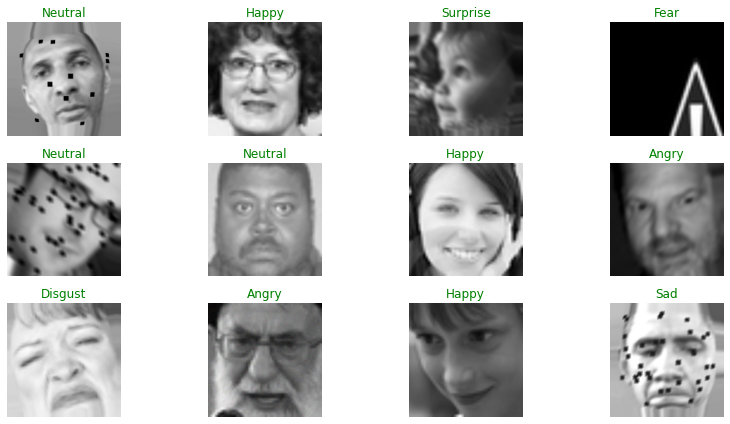

In [ ]:
display_image_grid(images, labels) #check augmentation correctness

#Pretrained landmark detector

In [ ]:
!wget -nd https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat

--2021-05-20 09:53:13--  https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat [following]
--2021-05-20 09:53:14--  https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>]  95.08M   103MB/s    in 0.9s    

2021-05-20 09:53:16 (103 M

In [ ]:
# creating landmark predictor
p = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [ ]:
# method to convert landmark predicted parts into list of coordinates
def get_landmarks_coords(image):
  face = detector(image, 0)
  if not bool(face):
    return []
  face = face[0]
  landmarks = predictor(image, face)
  landmarks_list = []
  for i in range(0, landmarks.num_parts):
    # save landmark coordinates
    x, y = landmarks.part(i).x, landmarks.part(i).y
    landmarks_list.append((x,y))
  return landmarks_list

# simple visualisation to check correctness
def show_landmarks(image, landmarks):
    for xy in landmarks:
      cv2.circle(image, (xy[0], xy[1]), 1, (168, 0, 20), -1)
    cv2_imshow(image)

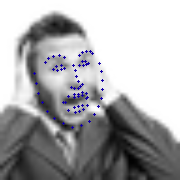

Fear


In [ ]:
# checking landmark predictor on random image
sample_num = 17
img = images[sample_num]

landmarks_list = get_landmarks_coords(img)
show_landmarks(img, landmarks_list)
print(classes[labels[sample_num]])

##Landmarks for train dataset

In [ ]:
def get_landmarks(images, labels, cut_landmarks=True):
  assert len(images) == len(labels)
  new_images = []
  new_labels = []
  new_landmarks = []
  
  for i, img in enumerate(images):
    landmarks_list = get_landmarks_coords(img)
    if cut_landmarks:
      landmarks_list = landmarks_list[17:]
    if landmarks_list:
      new_images.append(img)
      new_labels.append(labels[i])
      new_landmarks.append(landmarks_list)
  return (new_images, new_labels, new_landmarks)

In [ ]:
# create landmarks for images
images, labels, landmarks = get_landmarks(images, labels)

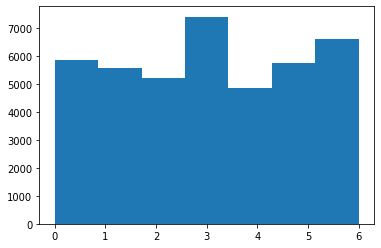

Distribution of classes after augmentation. Train size = 41327


In [ ]:
# create dataframe with landmarks
landamark_dataset = pd.DataFrame({"pixels": images, "emotion" : labels, "landmarks" : landmarks})
plt.hist(landamark_dataset['emotion'], bins=7)
plt.show()
print("Distribution of classes after augmentation. Train size =", len(landamark_dataset))
# landamark_dataset.to_csv('train_landmark.csv', index=False)

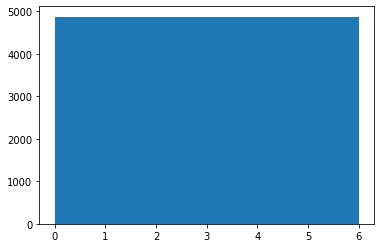

In [ ]:
a = landamark_dataset.groupby('emotion')
landamark_dataset = pd.DataFrame(a.apply(lambda x: x.sample(a.size().min()).reset_index(drop=True)))
landamark_dataset.reset_index(drop=True, inplace=True)
plt.hist(landamark_dataset['emotion'], bins=7)
plt.show()

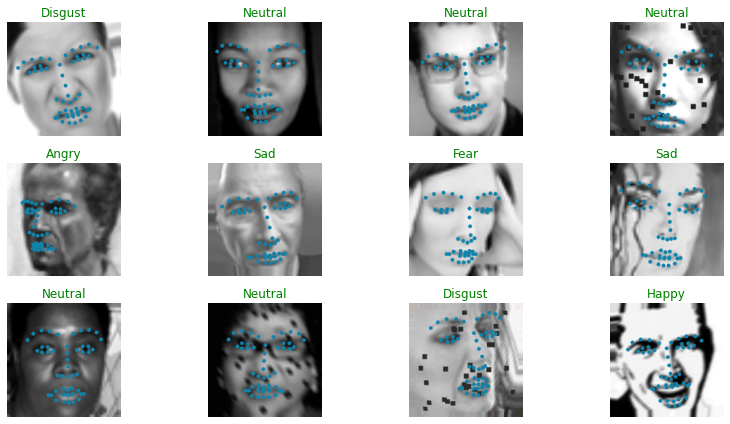

In [ ]:
display_image_grid(images, labels, landmarks) # check landmarks correctness
del images, labels, landmarks

In [ ]:
# image = cv2.cvtColor(n_images[17].astype('float32') * 255, cv2.COLOR_GRAY2BGR)
# cv2_imshow(image)
# a = transform(image=image)
# cv2_imshow(a["image"])

#Dataloader

In [ ]:
class FaceExpressionDataset(Dataset):

  def __init__(self, data, train=False):
    self.data = data
    self.train = train
    self.transform = transforms.Compose([transforms.ToTensor()])


  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx):
    img = self.transform(self.data["pixels"][idx])
    # img = self.data["pixels"][idx]


    if self.train:
      label = self.data["emotion"][idx]
      landmarks = self.data["landmarks"][idx]
      landmarks = np.array(landmarks).reshape(len(landmarks)*2,)
      landmarks = torch.from_numpy(landmarks).float()
      return (img, landmarks), label
    else:      
      return img

In [ ]:
def create_test_dataset(path):
  test_data = pd.read_csv(path)
  images = create_dataset(test_data, train=False)
  return FaceExpressionDataset(pd.DataFrame({"pixels": images}))

In [ ]:
train = landamark_dataset.sample(frac=0.7, random_state=13)#.reset_index(drop=True)
test = landamark_dataset.drop(train.index).reset_index(drop=True)
train.reset_index(drop=True, inplace=True)
train_set = FaceExpressionDataset(train, train=True)
test_set = FaceExpressionDataset(test, train=True)
del train, test

In [ ]:
validation_dataset = create_test_dataset("/content/dataset/test.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


In [ ]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
type(test_loader)

torch.utils.data.dataloader.DataLoader

#NN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.resnet18(pretrained=True,progress=True)
        self.net.trainable = False
        self.net.fc = nn.Linear(512, 7)

    def forward(self, x):
        return self.net(x)

# encHidDim1 = 32
# encHidDim2 = 21 
# encHidDim3 = 32
# encHidDim4 = 64

model_cnn = Net().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_cnn

Net(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
epochs = 30
lr = 0.005
model_path = "/content/drive/MyDrive/ACV/facial_recogn_less.pt"
optimizer = optim.Adam(model_cnn.parameters(), lr=lr, betas=(0.9, 0.98)) 
criterion_classifier = nn.CrossEntropyLoss()
criterion_landmark_predictor = nn.MSELoss()

##Train & test

In [ ]:
def train_2net(model, device, train_loader, criterion_c, criterion_p, optimizer, epoch):
    model.train()
    # criterion_c = nn.CrossEntropyLoss()
    # criterion_p = nn.MSELoss()
    # criterion = F.cross_entropy()
    loss_ = 0
    log_interval = 200
    for batch_idx, ((data, landmarks), target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        # landmarks = landmarks.to(device)
        
        # Classifier
        optimizer.zero_grad()
        output = model(data)
        loss_c = criterion_c(output, target)
        loss_c.backward()
        optimizer.step()
        loss_ += loss_c.item()

        # Predictor
        # optimizer.zero_grad()
        # output = model(data, task='predict')

        # loss_p = criterion_p(output, landmarks)
        # loss_p.backward()
        # optimizer.step()
        # loss_ += loss_p.item()

        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_ / log_interval))
            loss_ = 0

In [ ]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    # criterion = nn.CrossEntropyLoss()
    correct = 0
    with torch.no_grad():
        for (data,_), target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # print(output[0])
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, epochs + 1):
    # train(model_cnn, device, train_loader, optimizer, epoch)
    train_2net(model_cnn, device, train_loader, criterion_classifier, criterion_landmark_predictor, optimizer, epoch)
    if epoch % 5 == 0:
      test(model_cnn, device, test_loader, criterion_classifier)
    torch.save(model_cnn.state_dict(), model_path)

Train Epoch: 1 [12800/23858 (53%)]	Loss: 2.041636
Train Epoch: 2 [12800/23858 (53%)]	Loss: 1.743656
Train Epoch: 3 [12800/23858 (53%)]	Loss: 1.384403
Train Epoch: 4 [12800/23858 (53%)]	Loss: 1.195204
Train Epoch: 5 [12800/23858 (53%)]	Loss: 1.048569

Test set: Average loss: 0.0243, Accuracy: 4589/10225 (44.88%)

Train Epoch: 6 [12800/23858 (53%)]	Loss: 0.904699
Train Epoch: 7 [12800/23858 (53%)]	Loss: 0.743204
Train Epoch: 8 [12800/23858 (53%)]	Loss: 0.593390
Train Epoch: 9 [12800/23858 (53%)]	Loss: 0.430720
Train Epoch: 10 [12800/23858 (53%)]	Loss: 0.320730

Test set: Average loss: 0.0248, Accuracy: 6139/10225 (60.04%)

Train Epoch: 11 [12800/23858 (53%)]	Loss: 0.237236
Train Epoch: 12 [12800/23858 (53%)]	Loss: 0.202914
Train Epoch: 13 [12800/23858 (53%)]	Loss: 0.160289
Train Epoch: 14 [12800/23858 (53%)]	Loss: 0.143928
Train Epoch: 15 [12800/23858 (53%)]	Loss: 0.125384

Test set: Average loss: 0.0269, Accuracy: 6587/10225 (64.42%)

Train Epoch: 16 [12800/23858 (53%)]	Loss: 0.117860
T

##Accuracy & Visualisation

In [ ]:
def per_class_accuracy(net, testloader):
    class_correct = [.0] * len(classes)
    class_total = [.0] * len(classes)
    with torch.no_grad():
        for (data, _), target in testloader:
            data = data.to(device)
            target = target.to(device)
            outputs = net(data)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == target).squeeze()
            for i in range(len(target)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
per_class_accuracy(model_cnn, test_loader)

Accuracy of Angry : 67 %
Accuracy of Disgust : 86 %
Accuracy of  Fear : 39 %
Accuracy of Happy : 80 %
Accuracy of   Sad : 44 %
Accuracy of Surprise : 75 %
Accuracy of Neutral : 63 %


In [ ]:
def visualise_model_performance(net, testloader, size=(3,4)):
    net.eval()

    num_of_samples = size[0]*size[1]
    figure, ax = plt.subplots(nrows=size[0], ncols=size[1], figsize=(12, 6))
    (images, _), labels = next(iter(testloader))

    d_images = images.to(device)
    outputs = net(d_images).to(device)
    _, predicted_labels = torch.max(outputs, 1)

    # landmarks = net(d_images, task='predict').to(device)

    for i in range(num_of_samples):
      image = images[i].permute(1, 2, 0).numpy().copy()
      image = (image * 255).astype(np.uint8)
      true_label = labels[i]
      predicted_label = predicted_labels[i].item()
      color = "green" if true_label == predicted_label else "red"
      
      # for x, y in landmarks[i].detach().cpu().numpy().reshape((51, 2)):
      #   cv2.circle(image, (int(x), int(x)), 1, (17, 131, 53), -1)

      ax.ravel()[i].imshow(image)
      ax.ravel()[i].set_title("True label: {}\nPredicted label: {}".format(classes[true_label], classes[predicted_label]), color=color)
      ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()


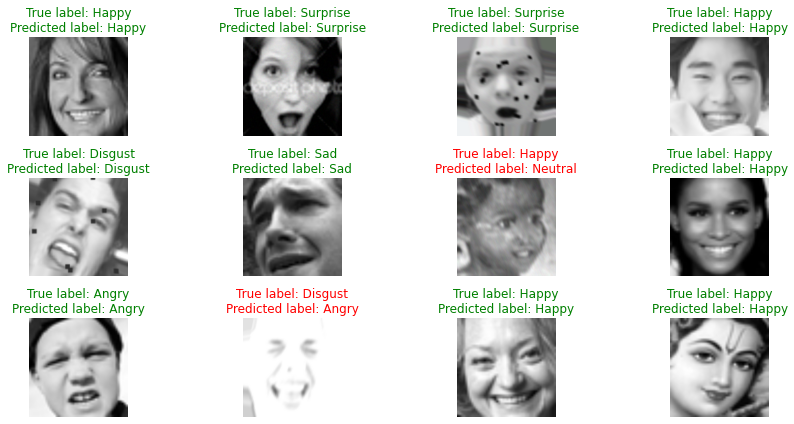

In [ ]:
visualise_model_performance(model_cnn, test_loader)

In [ ]:
# model_cnn = Net().to(device)
# model_cnn.load_state_dict(torch.load(model_path))